Importo as bibliotecas necessárias

In [42]:
import glob
import pandas as pd
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd

from collections import Counter
from scipy.spatial.distance import pdist,squareform


In [43]:
%matplotlib inline

Carrega todos os dados da pasta "dados_camara" e mesclo tudo em um únido dataframe, dando um join nos dados pelas colunas: nome, partido e uf

In [44]:
votacoes = None
matchColumns = ["nome","partido","uf"]
for _file in glob.glob('./dados_senado/*.csv'):
    if votacoes is None:
        votacoes = pd.read_csv(_file, encoding='utf-8')
    else:
        votacoes = pd.merge(left=votacoes, right=pd.read_csv(_file, encoding='utf-8'), how="outer", left_on=matchColumns, right_on=matchColumns)

In [45]:
votacoes.shape

(75, 40)

In [46]:
votacoes.fillna(0, inplace=True)

In [47]:
estados = votacoes.uf
estados = pd.Series([unicodedata.normalize("NFKD", e).strip() for e in estados])

In [48]:
estados_regioes = {('SP','MG','RJ','ES') : 'SE' ,
           ('DF','MT','MS','GO') : 'CO' ,
           ('RS','PR','SC') : 'SU' ,
           ('AL','BA','CE','MA','PB','PE','PI','RN','SE') : 'NE',
           ('AC','AP','AM','PA','RO','RR','TO') : 'NO'}

In [49]:
regioes = pd.Series([estados_regioes[k] for e in estados for k in estados_regioes.keys()  if e in k])

In [50]:
votos = votacoes.iloc[:,3:votacoes.shape[1]]
votos = votos[(votos.T != 0).any()]
votacoes = votacoes.iloc[votos.index.tolist(),:]

In [51]:
deputados = votacoes.nome

In [52]:
partidos = votacoes.partido

In [53]:
votacoes.shape


(75, 40)

In [54]:
votos.shape

(75, 37)

In [55]:
corr = np.corrcoef(votos)

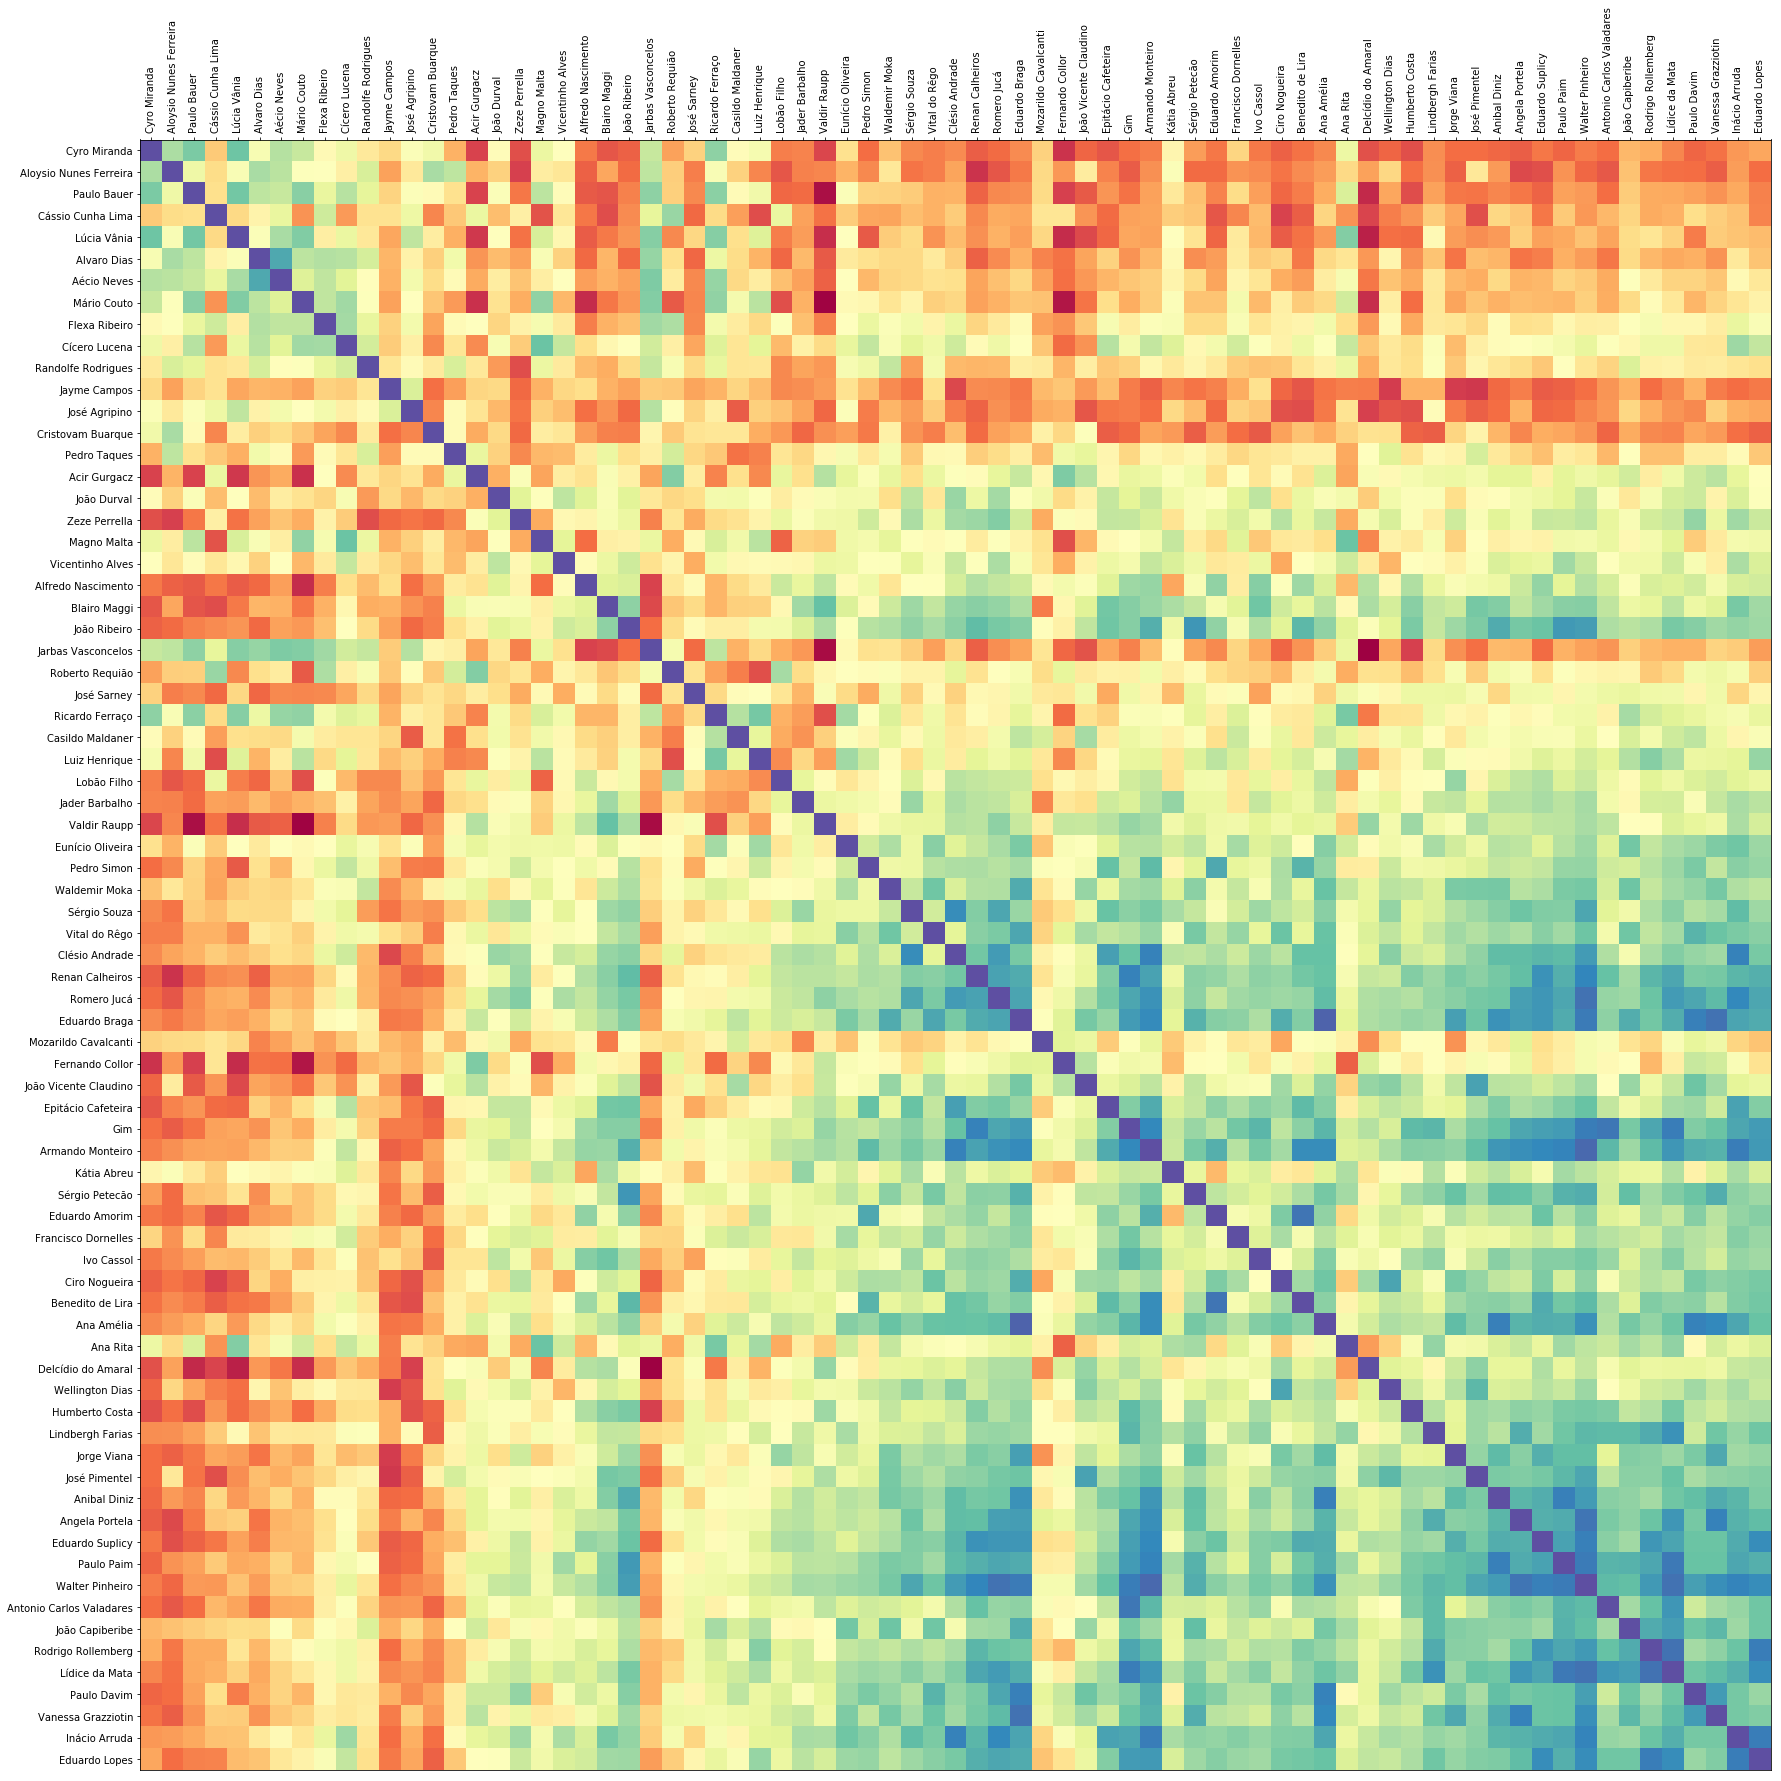

In [56]:
fig,ax = plt.subplots(figsize=(40,30))
ax.imshow(corr,cmap=plt.get_cmap('Spectral'))
ax.set_yticks(range(len(deputados)))
ax.set_yticklabels(deputados)
ax.set_xticks(range(len(deputados)))
ax.set_xticklabels(deputados,rotation=90)
ax.xaxis.tick_top()

In [57]:
U, Sigma, V = svd(corr)

In [58]:
afinidade = U[:,0]

In [59]:
cut =  np.sum(afinidade < np.mean(afinidade)) - 0.5

In [60]:
iafinidade = np.argsort(afinidade)
corr_afinidade = corr[iafinidade,:]
corr_afinidade = corr_afinidade[:,iafinidade]

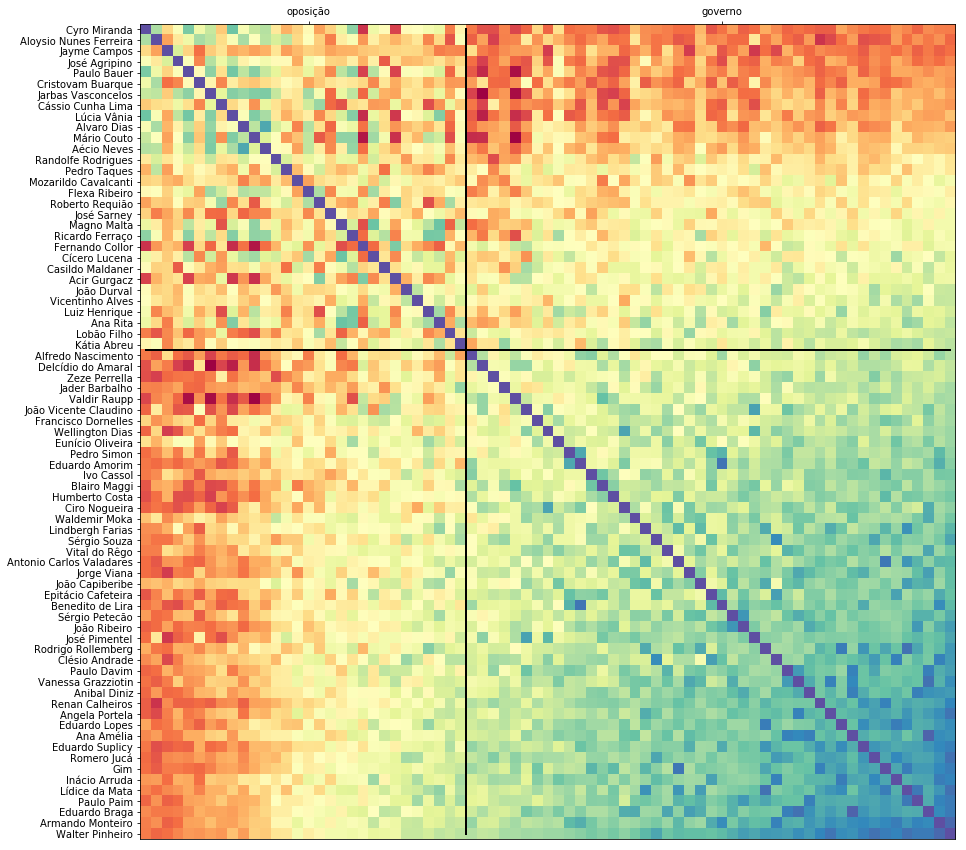

In [61]:
fig,ax = plt.subplots(figsize=(20,15))
ax.imshow(corr_afinidade,cmap=plt.get_cmap('Spectral'))
ax.plot([0,74],[cut,cut],color='black',lw=2)
ax.plot([cut,cut],[0,74],color='black',lw=2)
ax.set_xticks([15,53])
ax.set_yticks(range(len(deputados)))
ax.set_xticklabels([u"oposição",u"governo"])
ax.set_yticklabels(deputados[iafinidade])
ax.xaxis.tick_top()

In [62]:
part_ord = np.lexsort([iafinidade,partidos])
corr_partido = corr[part_ord,:]
corr_partido = corr_partido[:,part_ord]

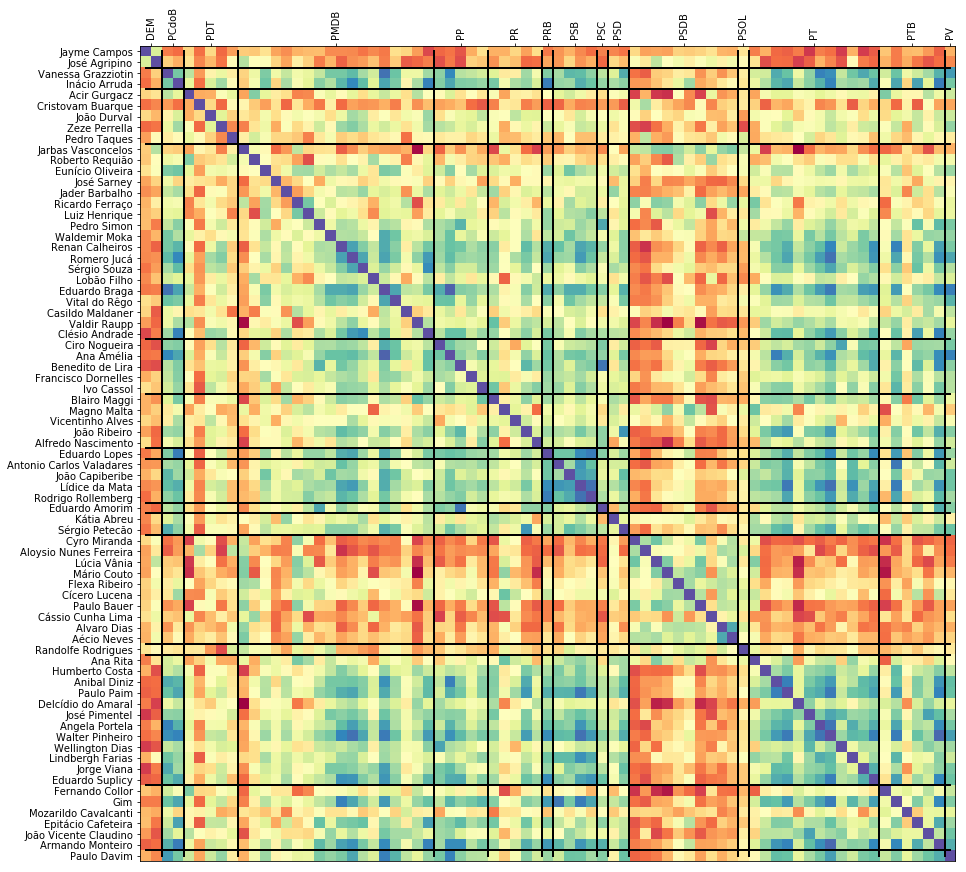

In [63]:
splits = [i for i in range(len(partidos)-1) if partidos[i] != partidos[i+1]]
fig,ax = plt.subplots(figsize=(20,15))
partido_ord=pd.Series(partidos[part_ord].reset_index(drop=True))
splits = [i for i in range(len(partido_ord)-1) if partido_ord[i] != partido_ord[i+1]]
cj_partidos = set(partido_ord) 
pos = [np.mean(np.where(partido_ord==p))  for p in cj_partidos]

ax.imshow(corr_partido ,cmap=plt.get_cmap('Spectral'))
for i in splits:
    ax.plot([0,74],[i+0.5,i+0.5],color='black',lw=2)
    ax.plot([i+0.5,i+0.5],[0,74],color='black',lw=2)
    
ax.set_xticks(pos)
ax.set_yticks(range(len(deputados)))
ax.set_xticklabels(cj_partidos,rotation=90)
ax.set_yticklabels(deputados[part_ord])
ax.xaxis.tick_top()

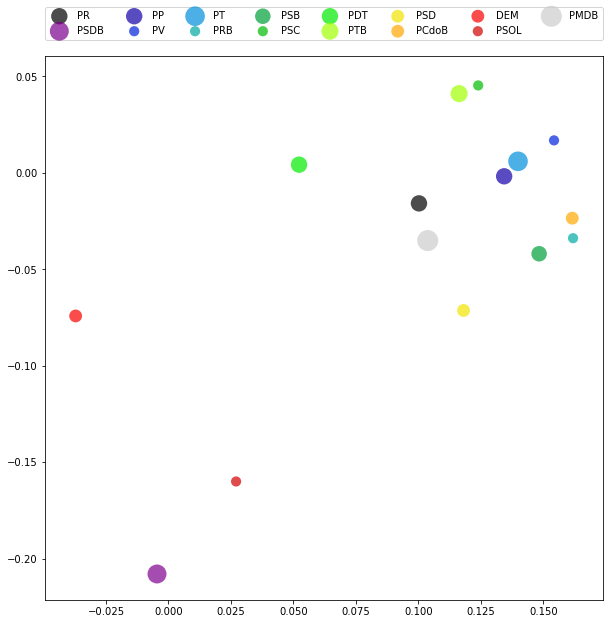

In [64]:
rgb_values = plt.get_cmap("nipy_spectral", len(cj_partidos))
colors = [rgb_values(i) for i in range(len(cj_partidos))]
cmap = dict(zip(cj_partidos,colors))
counts = Counter(partidos)

fig, ax = plt.subplots(figsize=(10,10))
for p in cj_partidos:
    pts = partidos[partidos==p].index
    ax.scatter(np.mean(U[pts,0]),np.mean(U[pts,1]), c=cmap[p], s = np.log(counts[p]+1)*150, label=p,
               alpha=0.7, edgecolors='none')

ax.legend(loc=9,ncol=(len(cj_partidos)+1)/2,bbox_to_anchor=(0.5, 1.1))

In [65]:
reg_ord = np.lexsort([iafinidade,regioes])
corr_regiao = corr[reg_ord,:]
corr_regiao = corr_regiao[:,reg_ord]

/Users/robin/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


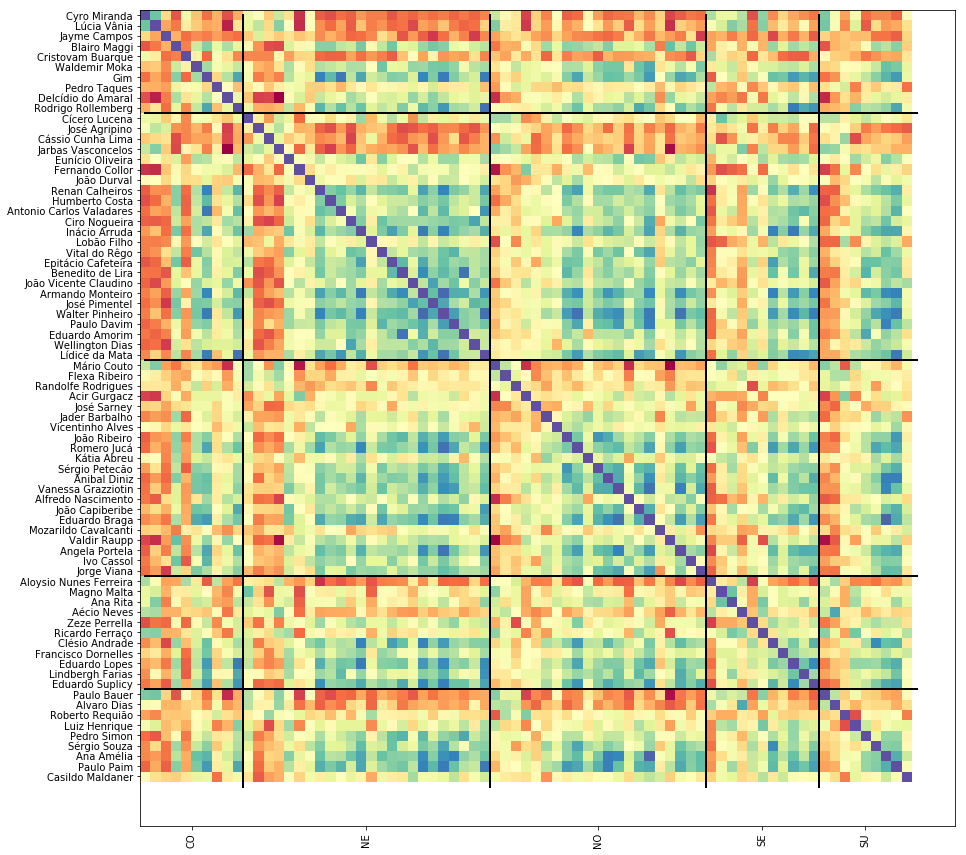

In [66]:
fig,ax = plt.subplots(figsize=(20,15))
regioes_ord = pd.Series(regioes[reg_ord].reset_index(drop=True))
splits = [i for i in range(len(regioes_ord)-1) if regioes_ord[i] != regioes_ord[i+1]]
cj_regioes = set(regioes_ord) 
pos = [np.mean(np.where(regioes_ord==p))  for p in cj_regioes]

ax.imshow(corr_regiao,cmap=plt.get_cmap('Spectral'))
for i in splits:
    ax.plot([0,votos.shape[0]],[i+0.5,i+0.5],color='black',lw=2)
    ax.plot([i+0.5,i+0.5],[0,votos.shape[0]],color='black',lw=2)
    
ax.set_xticks(pos)
ax.set_yticks(range(len(deputados)))
ax.set_xticklabels(cj_regioes,rotation=90)
ax.set_yticklabels(deputados[reg_ord])
fig.show()

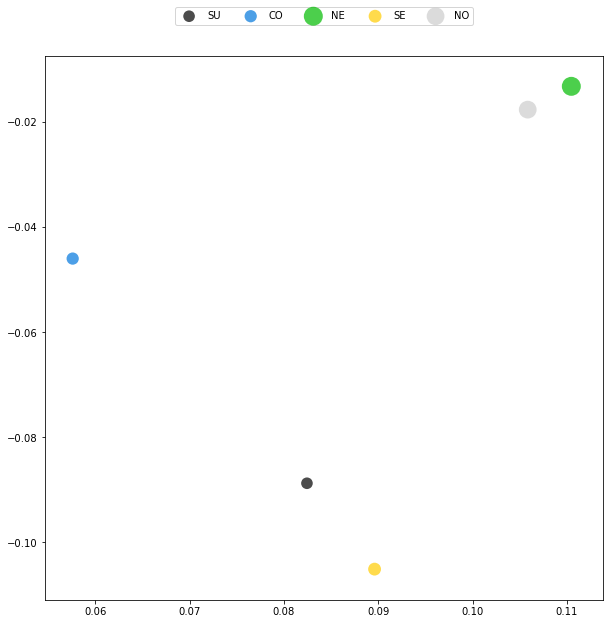

In [67]:
rgb_values = plt.get_cmap("nipy_spectral", len(cj_regioes))
colors = [rgb_values(i) for i in range(len(cj_regioes))]
cmap = dict(zip(cj_regioes,colors))
counts = Counter(regioes)

fig, ax = plt.subplots(figsize=(10,10))
for p in cj_regioes:
    pts = regioes[regioes==p].index
    ax.scatter(np.mean(U[pts,0]),np.mean(U[pts,1]), c=cmap[p], s = counts[p]*15, label=p,
               alpha=0.7, edgecolors='none')

ax.legend(loc=9,ncol=(len(cj_partidos)+1)/2,bbox_to_anchor=(0.5, 1.1))
fig.show()

In [68]:
acertos = []
por_partido = {
    'PT' : [],
    'PMDB' : [],
    'PSDB' : [],
}
for votacao in range(1,votos.shape[1]):
    d = squareform(pdist(votos.iloc[:,range(votacao)]))
    np.fill_diagonal(d,float('inf'))
    nn = [np.random.choice(np.argwhere(d[i,:] == np.amin(d[i,:]))[0]) for i in range(len(d))] 
    prediction = votos.iloc[nn,votacao].reset_index(drop=True)
    acertos.append(np.mean(prediction == votos.iloc[:,votacao]))
    for p in por_partido.keys():
        sset = np.where(partidos==p)[0]
        por_partido[p].append(np.mean(prediction.iloc[sset] == votos.iloc[sset,votacao]))

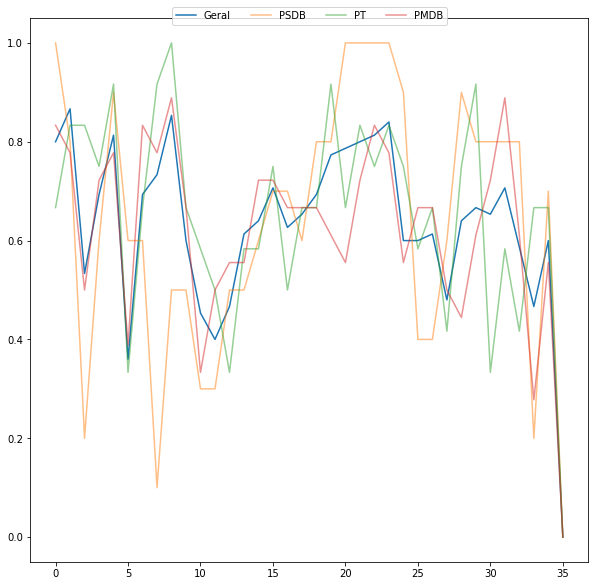

In [69]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(acertos,label="Geral")
for p in por_partido.keys():
    ax.plot(por_partido[p],label=p,alpha=0.5)
ax.legend(loc=9,ncol=4,bbox_to_anchor=(0.5, 1.03))
plt.show()